In [1]:
BATCH_SIZE = 10_000
#BATCH_SIZE = 2048
#BATCH_SIZE = 512
PAD_SIZE = 80
TARGET_LABELS = [
    "Solved",
    "Improvement",
    "AreaRatio",
    "FirstUpdate",
    "Stacks"
]

SEED = 3093453

# Preprocessing

## Load Packages and Data

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(SEED)

tf.random.set_seed(SEED)

sns.set(
    context="talk",
    style="darkgrid"
)

In [3]:
cwd = os.getcwd()
cwd, _ = os.path.split(cwd)
cwd

'/Users/fynn/Uni/MA'

In [4]:
import tensorflow as tf
from tensorflow import keras

samples = os.path.join(cwd, "data", "2D", "MIP")
class_names = ["interrupted", "solved"]

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.2,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.2,
    subset = "validation",
    follow_links = False
)

class_names = np.array(class_names)

Found 710800 files belonging to 2 classes.
Using 568640 files for training.


2023-11-02 12:05:01.654281: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-02 12:05:01.654341: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-02 12:05:01.654345: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-02 12:05:01.654402: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-02 12:05:01.654424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 710800 files belonging to 2 classes.
Using 142160 files for validation.


In [5]:
for X,y in train_dataset.take(1):
    pass

In [6]:
#y = pd.Series(X.numpy().astype(str)).str.extractall("MIP Improvement( )")
#y = y.groupby(y.index.get_level_values(0)).count().to_numpy()[:,0]
#y = y == 1
print(y.numpy().mean())

0.3958


In [7]:
df = pl.DataFrame({"raw": X.numpy().astype(str)})
print(df[0, 0])

dataset: X
instance: SA7
+-----------+
2D Packing MIP with Time Limit 19.029396103038952 [s] in Truck P233050811
Stack 0 with items: ['0090017100_14062023025620', '0090017100_14062023025620']
Stack 1 with items: ['0090017100_14062023025620', '0090017100_14062023025620']
Stack 2 with items: ['0090017100_14062023025620', '0090017100_14062023007279']
Stack 3 with items: ['0090017100_14062023007279', '0090017100_14062023007279']
Stack 4 with items: ['0090017100_14062023007279', '0090017100_14062023007279']
Stack 5 with items: ['0090017100_14062023007279', '0090017100_14062023007279']
Stack 6 with items: ['0090017100_14062023004027', '0090017100_14062023004027']
Stack 7 with items: ['0090017100_14062023004027', '0090017100_14062023004027']
Stack 8 with items: ['0090017100_14062023004027', '0090017100_14062023004027']
Stack 9 with items: ['0090017100_14062023004027', '0090017100_14062023004027']
Stack 10 with items: ['0090017100_14062023004027', '0090017100_14062023004027']
Stack 11 with ite

## Loading CSVs

In [8]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident" # drop because of rename earlier
]).unique()

items.collect().head()

Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth,NestedHeight
i64,str,i64,str,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool,f64
90016100,"""K11""",90016900,"""GRD1""","""100019127R""","""MFM---0474""",2.3,1.6,1.0,1.5736,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.955
22060301,null,90016900,"""169GB-30""","""756F09177R""","""SLI---1200""",1.6,1.2,0.93,0.5221,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.885
2695000,null,90016900,"""GRF1""","""271002239R""","""ECM---6655""",2.4,1.2,0.76,0.243,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.715
90016100,"""K11""",90016900,"""GRD1""","""100018674R""","""MFM---0474""",2.3,1.6,1.0,1.57,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.955
2573222,null,90016900,"""GRD1""","""544010095R""","""ECM---4853""",1.2,1.2,0.688,0.16524,0.0,"""C""","""BY""","""0090016900_270…",false,false,0.688


In [9]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)
truck_stops.collect().head()

Supplier code,Supplier loading order,Supplier dock,Supplier dock loading order,Plant dock,Plant dock loading order,truck_id,dataset,instance
i64,i64,str,i64,str,i64,str,str,str
29908700,1,null,1,"""X4""",1,"""P187730401""","""A""","""AS"""
62059600,1,null,1,"""X0""",1,"""P187731001""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P188730403""","""A""","""AS"""
62059600,1,null,1,"""X0""",1,"""P190731051""","""A""","""AS"""
62069400,1,null,1,"""X0""",1,"""P192711301""","""A""","""AS"""


In [10]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Length", "Width", "Max weight",
              "EMmm", "EMmr"
             ]

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id", "Max weight": "Weight"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)

truck_dims = truck_dims.with_columns([
    (pl.col("Length") / 1000),
    (pl.col("Width") / 1000),
    (pl.col("Weight") / 1000),
    (pl.col("EMmm") / 1000),
    (pl.col("EMmr") / 1000),
])

truck_dims.collect().head()

truck_id,Length,Width,Weight,EMmm,EMmr,dataset,instance
str,f64,f64,f64,f64,f64,str,str
"""P187730405""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P188730401""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189730503""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189731005""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P190725951""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""


## Preprocessing Functions:

In [11]:
import sys
sys.path.append("..")

from utils.preprocessing import extract_raw_data, explode_instances_into_stacks, explode_stacks_into_items
from utils.preprocessing import join_items, group_items_by_stack, join_truck_loading_order, append_truck_info

In [12]:
XX = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    .pipe(append_truck_info, truck_dims)
    .collect()
    .to_numpy()
)

XX

array([[0, 1.206, 1.01, ..., 0.0, '1-1-1', False],
       [0, 1.8, 1.2, ..., 0.0, '1-1-1', False],
       [0, 1.8, 1.2, ..., 0.0, '1-1-1', False],
       ...,
       [9999, 2.35, 1.32, ..., 0.0, '1-1-1', False],
       [9999, 2.35, 1.32, ..., 0.0, '1-1-1', False],
       [9999, 13.5, 2.44, ..., 31.5, '0-0-0', False]], dtype=object)

In [26]:
def get_tensor_representation(X, packing_clm=6):

    # add columns for Length and Width Remainder
    X = np.append(X, np.zeros((X.shape[0], 2)), axis=1)
    
    indices = np.unique(X[:, 0])
    indices = np.sort(indices)

    # (batch_size, ?, features)
    X = np.array([X[X[:,0] == idx] for idx in indices], dtype = "object")

    # replace the packing order with the stop index (i.e 1-1-1 and 1-1-2 turn to 0 and 1, respectively)
    #packing_clm = min([i for i, clm in enumerate(df.columns) if clm == "packing_order"])
    
    for i, x in enumerate(X):
        packing_order = x[:,packing_clm]
        stops = np.unique(packing_order)
        stops = np.sort(stops)
        stops = {stop: j for j, stop in enumerate(stops)}
        stops = [stops[order] for order in packing_order]
        X[i][:,packing_clm] = stops

    # pad the variable length number of stacks into fixed
    #  (batch_size, pad_size, features)
    X = tf.keras.utils.pad_sequences(X, maxlen=PAD_SIZE, padding = "post", dtype="float64")
    # drop the index column (batch_size, pad_len, n_features)
    X = X[:,:,1:].astype(float)

    # Add Length and width Remainder
    for xx in X:
        truck_width = max(xx[:,1])
        # Length Remainder
        xx[:,-2] = truck_width % xx[:,0]
        # Width Remainder
        xx[:,-1] = truck_width % xx[:,1]
    
    X = np.nan_to_num(X)
    
    return X

c = get_tensor_representation(XX)
c.shape

(10000, 80, 9)

In [14]:
def get_additional_labels(df: pl.DataFrame) -> dict[str: np.array]:
    """
    """

    pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
    mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]

    # mip_improvements: pl.Series[list[str]]
    # with entries according to the pattern, i.e all MIP improvement rows
    
    y_num_improvements = mip_improvements.list.len()-1
    
    y_improvement = y_num_improvements > 0

    y_packed_area_ratio = mip_improvements.list[-1].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)

    y_packed_area = mip_improvements.list[-1].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)

    y_first_update = mip_improvements.list[1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32).fill_null(0)
    
    y_last_update = mip_improvements.list[-1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32)

    # missing stacks:
    y_stack_not_included = np.zeros((len(df), PAD_SIZE), dtype=float)
    pattern = "Stack (\d*) not in final solution with items:"
    x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
    
    for i, missing_stacks in enumerate(x):
        for j in missing_stacks:
            y_stack_not_included[i, j] +=1


    y = [
        #y_num_improvements.to_numpy(),
        y_improvement.to_numpy().astype(int),
        y_packed_area_ratio.to_numpy(),
        #y_packed_area.to_numpy(),
        np.log1p(y_first_update.to_numpy()),
        #y_last_update.to_numpy(),
        y_stack_not_included
    ]
    
    return y

#pattern = "Stack (\d*) not in final solution with items:"
#df["raw"].str.extract_all(pattern).apply(lambda x: [i.split(" ")[1] for i in x])
#x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])

In [15]:
pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]
y_num_improvements = mip_improvements.list.len()-1
y_improvement = y_num_improvements > 0
y_improvement.mean()

0.4716

In [16]:
y_stack_not_included = np.zeros((BATCH_SIZE, PAD_SIZE), dtype=float)
pattern = "Stack (\d*) not in final solution with items:"
x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
    
for i, missing_stacks in enumerate(x):
    for j in missing_stacks:
        y_stack_not_included[i, j] +=1

y_stack_not_included.mean()

0.01619625

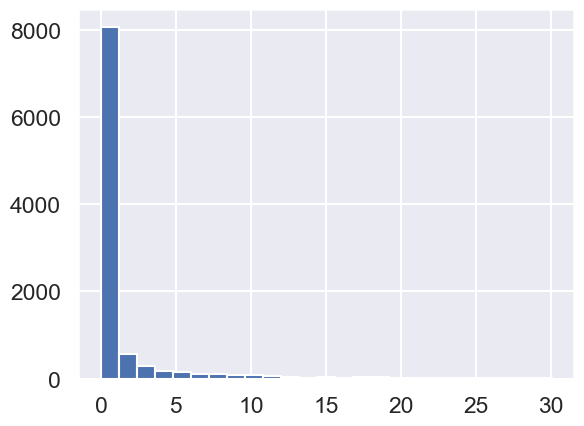

In [17]:
y_first_improvement = mip_improvements.list[1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32).fill_null(0)
plt.hist(y_first_improvement, bins=25);

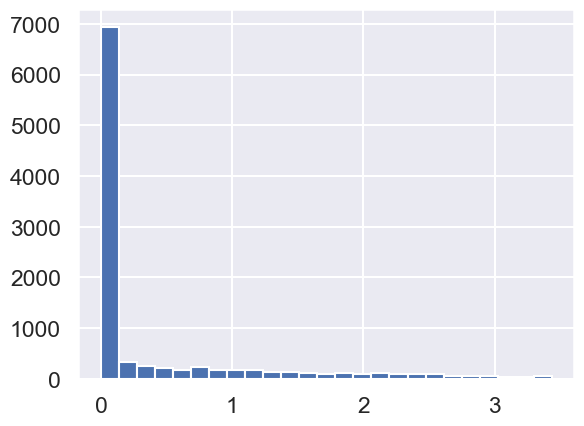

In [18]:
plt.hist(np.log1p(y_first_improvement), bins=25);

In [19]:
def polars_transformation(X_batch, y_batch, shuffle=True) -> (np.array, np.array):
    """

    Returns:
    --------
    X: np.array[float32]
        3D Feature Tensor of shape (Batch_size, Pad_size, n_features=7)

        - Batch_size: Truck Optimization Instances
        - Pad_size: Stacks (or Trucks), padded up to create tensors
        - n_features: Length, Width, Weight, L/W Forced Orientation
                      packing order, is_truck
    """
    
    df = pl.DataFrame({"raw": X_batch.numpy().astype(str)})
    
    X = (
        df.lazy()
        .pipe(extract_raw_data)
        .pipe(explode_instances_into_stacks)
        .pipe(explode_stacks_into_items)
        .pipe(join_items, items)
        .pipe(group_items_by_stack)
        .pipe(join_truck_loading_order, truck_stops)
        .pipe(append_truck_info, truck_dims)
        .collect()
        .to_numpy()
    )

    X = get_tensor_representation(X)

    # fill final column with bool for stack not in initial solution
    pattern = "Stack (\d*) missing:"
    x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])

    for i, missing_stacks in enumerate(x):
        for j in missing_stacks:
            X[i, j, 6] +=1

    
    # extract the time limit
    pattern = "2D Packing MIP with Time Limit (\d*\.?\d*) \[s\]"
    x_time_limit = df["raw"].str.extract(pattern).cast(pl.Float32).to_numpy()

    y_batch = y_batch.numpy()
    y_batch = [y_batch]
    y_extra = get_additional_labels(df)

    if shuffle:
        idx = np.arange(X.shape[1])
        idx = np.random.choice(idx, size=PAD_SIZE, replace=False)
        X = X[:,idx,:]
        y_extra[-1] = y_extra[-1][:,idx]

    
    y_batch += y_extra
    # Drop y_batch
    #y_batch = y_extra

    X = [X, x_time_limit]
    
    return X, y_batch

cx, cy = polars_transformation(X, y, shuffle=False)

In [20]:
cx[0][0].round(2)

array([[1.21e+00, 1.01e+00, 7.80e-01, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 3.00e-02, 4.20e-01],
       [1.80e+00, 1.20e+00, 5.20e-01, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 6.40e-01, 4.00e-02],
       [1.80e+00, 1.20e+00, 5.20e-01, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 6.40e-01, 4.00e-02],
       [1.80e+00, 1.20e+00, 5.20e-01, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 6.40e-01, 4.00e-02],
       [1.80e+00, 1.20e+00, 5.20e-01, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 6.40e-01, 4.00e-02],
       [1.80e+00, 1.20e+00, 5.20e-01, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 6.40e-01, 4.00e-02],
       [1.80e+00, 1.20e+00, 5.20e-01, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 6.40e-01, 4.00e-02],
       [1.80e+00, 1.20e+00, 5.20e-01, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 6.40e-01, 4.00e-02],
       [1.80e+00, 1.20e+00, 5.20e-01, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 6.40e-01, 4.00e-02],
       [1.80e+00, 1.20e+00, 5.20e-01,

# DNN

In [51]:
from tensorflow.keras.layers import Masking, BatchNormalization, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.layers import Add, Dense, Input, Reshape, Permute, Lambda, Concatenate
from keras import backend as K
from tensorflow.keras import Model

from utils.DNN.model_layers import TransformerEncoder


epoch = 7
model_path = os.path.join(cwd, "models", f"ModelImprovement-{epoch}.tf")

model = tf.keras.models.load_model(model_path)

In [52]:
k = BATCH_SIZE//10

y_pred = []

for i in range(0, BATCH_SIZE, k):
    x1 = cx[0][i:i+k]
    x2 = cx[1][i:i+k]
    xx = [x1, x2]

    y_pred.append(model(xx))


In [53]:
y_pred

[[<tf.Tensor: shape=(1000,), dtype=float32, numpy=
  array([0.6322148 , 0.27298805, 0.27540383, 0.25067818, 0.72873724,
         0.44437388, 0.3044844 , 0.9258224 , 0.6938575 , 0.9725094 ,
         0.5399524 , 0.35074452, 0.53328675, 0.47774762, 0.24648   ,
         0.11066014, 0.3111147 , 0.7239327 , 0.3750884 , 0.2564052 ,
         0.40436637, 0.38052335, 0.43370414, 0.85810274, 0.9905522 ,
         0.3980862 , 0.3271177 , 0.43109667, 0.42091733, 0.26753566,
         0.17841731, 0.5195454 , 0.33252764, 0.2986406 , 0.18378438,
         0.3890748 , 0.24680123, 0.52457684, 0.14238559, 0.41708198,
         0.6195798 , 0.30483422, 0.2039307 , 0.16610573, 0.9723324 ,
         0.3552156 , 0.43410218, 0.11814976, 0.28277513, 0.45682988,
         0.6922243 , 0.50395644, 0.72877175, 0.15229519, 0.13937558,
         0.6590618 , 0.77321965, 0.31632823, 0.9341558 , 0.69851303,
         0.22171664, 0.85737795, 0.4261554 , 0.2560584 , 0.22260644,
         0.28168127, 0.18160193, 0.2482071 , 0.82043

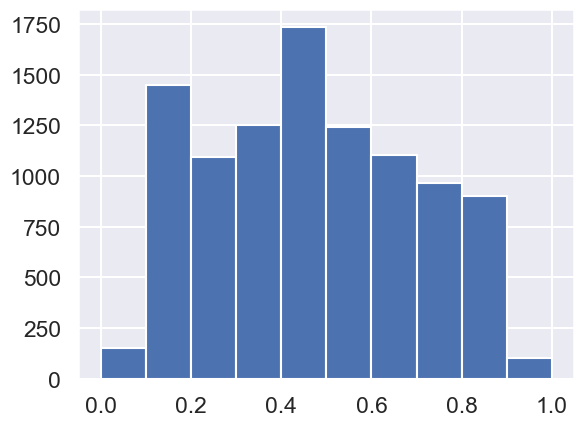

In [54]:
y_pred_improvement = np.concatenate([pred[1] for pred in y_pred])
y_pred_improvement

plt.hist(y_pred_improvement, bins=np.arange(0, 1.1, 0.1));

In [55]:
df = df.with_columns([
    pl.Series("y_pred_improvement", values=y_pred_improvement.round()),
    pl.Series("y_proba_improvement", values=y_pred_improvement),
    #pl.Series("label", values=y.numpy()[:,0]).cast(int),
    pl.Series("label", values=(df["raw"].str.extract_all("MIP Improvement").list.len() > 1)).cast(int),
    pl.Series("n_stops", values=np.max(c[:, :, 5], axis=1)).cast(int),
    pl.Series("n_stacks", values=np.argmin(c[:,:,0] > 0, axis=1))
])#.with_columns([])


df.head()

raw,y_pred_improvement,y_proba_improvement,label,n_stops,n_stacks
str,f32,f32,i64,i64,i64
"""dataset: X ins…",0.0,0.149976,0,1,16
"""dataset: X ins…",0.0,0.358387,0,1,20
"""dataset: X ins…",0.0,0.443568,0,1,27
"""dataset: X ins…",0.0,0.465123,0,1,22
"""dataset: B ins…",0.0,0.336665,0,2,15


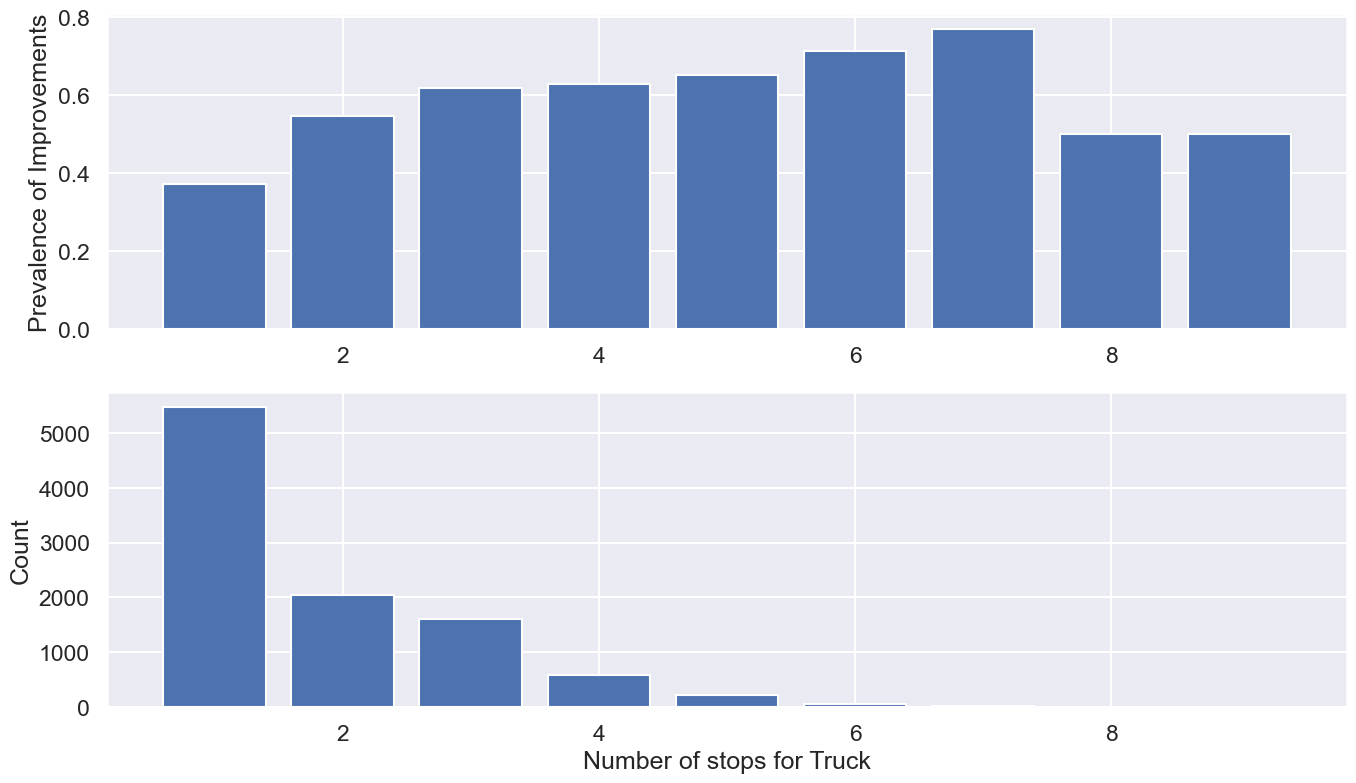

In [56]:
x = df.group_by("n_stops").agg([
    pl.mean("label").alias("Improvement prevalence"),
    pl.count("raw").alias("count")
]).sort("n_stops")

fig, ax = plt.subplots(2, figsize=(16, 9))

ax[0].bar(x["n_stops"], x["Improvement prevalence"]);
ax[1].bar(x["n_stops"], x["count"]);
ax[1].set(xlabel="Number of stops for Truck",
          ylabel="Count")
ax[0].set(xlabel="",
          ylabel="Prevalence of Improvements");

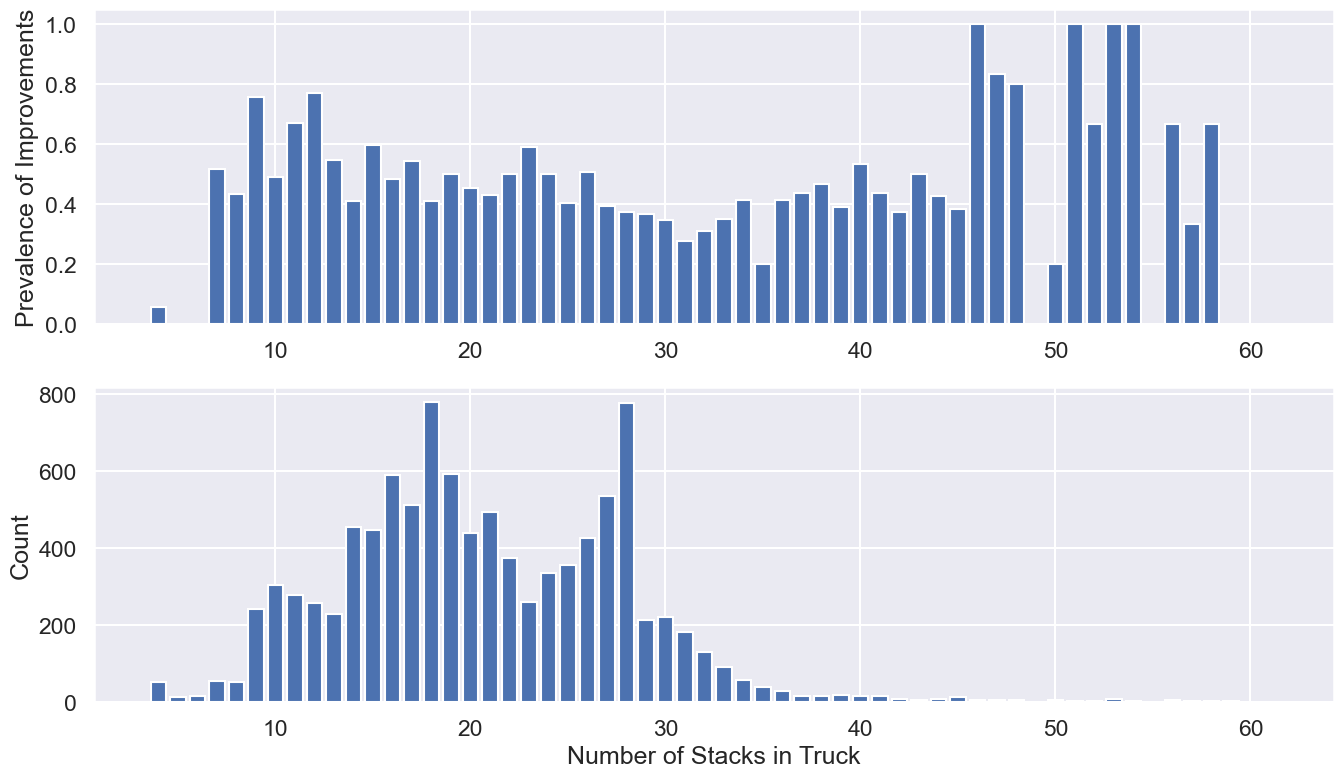

In [57]:
x = df.group_by("n_stacks").agg([
    pl.mean("label").alias("Improvement prevalence"),
    pl.count("raw").alias("count")
]).sort("n_stacks")

fig, ax = plt.subplots(2, figsize=(16, 9))

ax[0].bar(x["n_stacks"], x["Improvement prevalence"]);
ax[1].bar(x["n_stacks"], x["count"]);
ax[1].set(xlabel="Number of Stacks in Truck",
          ylabel="Count")
ax[0].set(xlabel="",
          ylabel="Prevalence of Improvements");

In [58]:
# Do Trucks with few stacks really always result in optimizations?

subdf = df.filter(
    pl.col("n_stacks") <10
)["raw"]

for raw in subdf.sample(10):
    print(raw)
    print("-"*100)
    
# after inspecting some instances, it sure seems like it.
# Which makes sense, since only not already solved instances
# are passed to the MIP Solver
# But since there are very few stacks, its easy to find the optimal solution
# which has not yet been found

dataset: X
instance: CI7
+-----------+
2D Packing MIP with Time Limit 30 [s] in Truck P208414501
Stack 0 with items: ['0090016800_14062023041089', '0090016800_14062023039754', '0090016800_14062023032321']
Stack 1 with items: ['0090016800_14062023031484', '0090016800_14062023028589', '0090016800_14062023028589']
Stack 2 with items: ['0090016800_14062023028589', '0090016800_14062023015240', '0090016800_14062023028589']
Stack 3 with items: ['0090016800_14062023015240', '0090016800_14062023011163', '0090016800_14062023000153']
Stack 4 with items: ['0090016800_14062023018286', '0090016800_14062023018286', '0090016800_14062023018286']
Stack 5 with items: ['0090016800_14062023023545', '0090016800_14062023021568', '0090016800_14062023021568']
Stack 6 with items: ['0090016800_14062023008863', '0090016800_14062023021573', '0090016800_14062023021573']
Stack 7 with items: ['0090016800_14062023008863', '0090016800_14062023008863', '0090016800_14062023021568']
MIP Improvement - 2D Vol: 19.9384 [m2] 

In [59]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, average_precision_score

clms = ["accuracy", "f1", "precision", "sensitivity", "average-precision"]
res = {}

for i, stop in df.group_by("n_stops"):
    acc = accuracy_score(stop["label"], stop["y_pred_improvement"])
    f1 = f1_score(stop["label"], stop["y_pred_improvement"])
    prc = precision_score(stop["label"], stop["y_pred_improvement"])
    sen = recall_score(stop["label"], stop["y_pred_improvement"])
    avg_prc = average_precision_score(stop["label"], stop["y_proba_improvement"])
    
    res[int(i)] = [acc, f1, prc, sen, avg_prc]

res = pd.DataFrame(res, index = clms).T
res

,accuracy,f1,precision,sensitivity,average-precision
8,0.666667,0.750000,0.600000,1.000000,0.916667
1,0.850484,0.784850,0.847727,0.730656,0.895104
9,0.750000,0.800000,0.666667,1.000000,1.000000
2,0.820639,0.831564,0.854839,0.809524,0.923076
3,0.777639,0.814390,0.840689,0.789687,0.915654
4,0.761017,0.807114,0.819444,0.795148,0.908811
5,0.755656,0.813793,0.808219,0.819444,0.906516
6,0.796610,0.860465,0.840909,0.880952,0.936766
7,0.692308,0.818182,0.750000,0.900000,0.865567


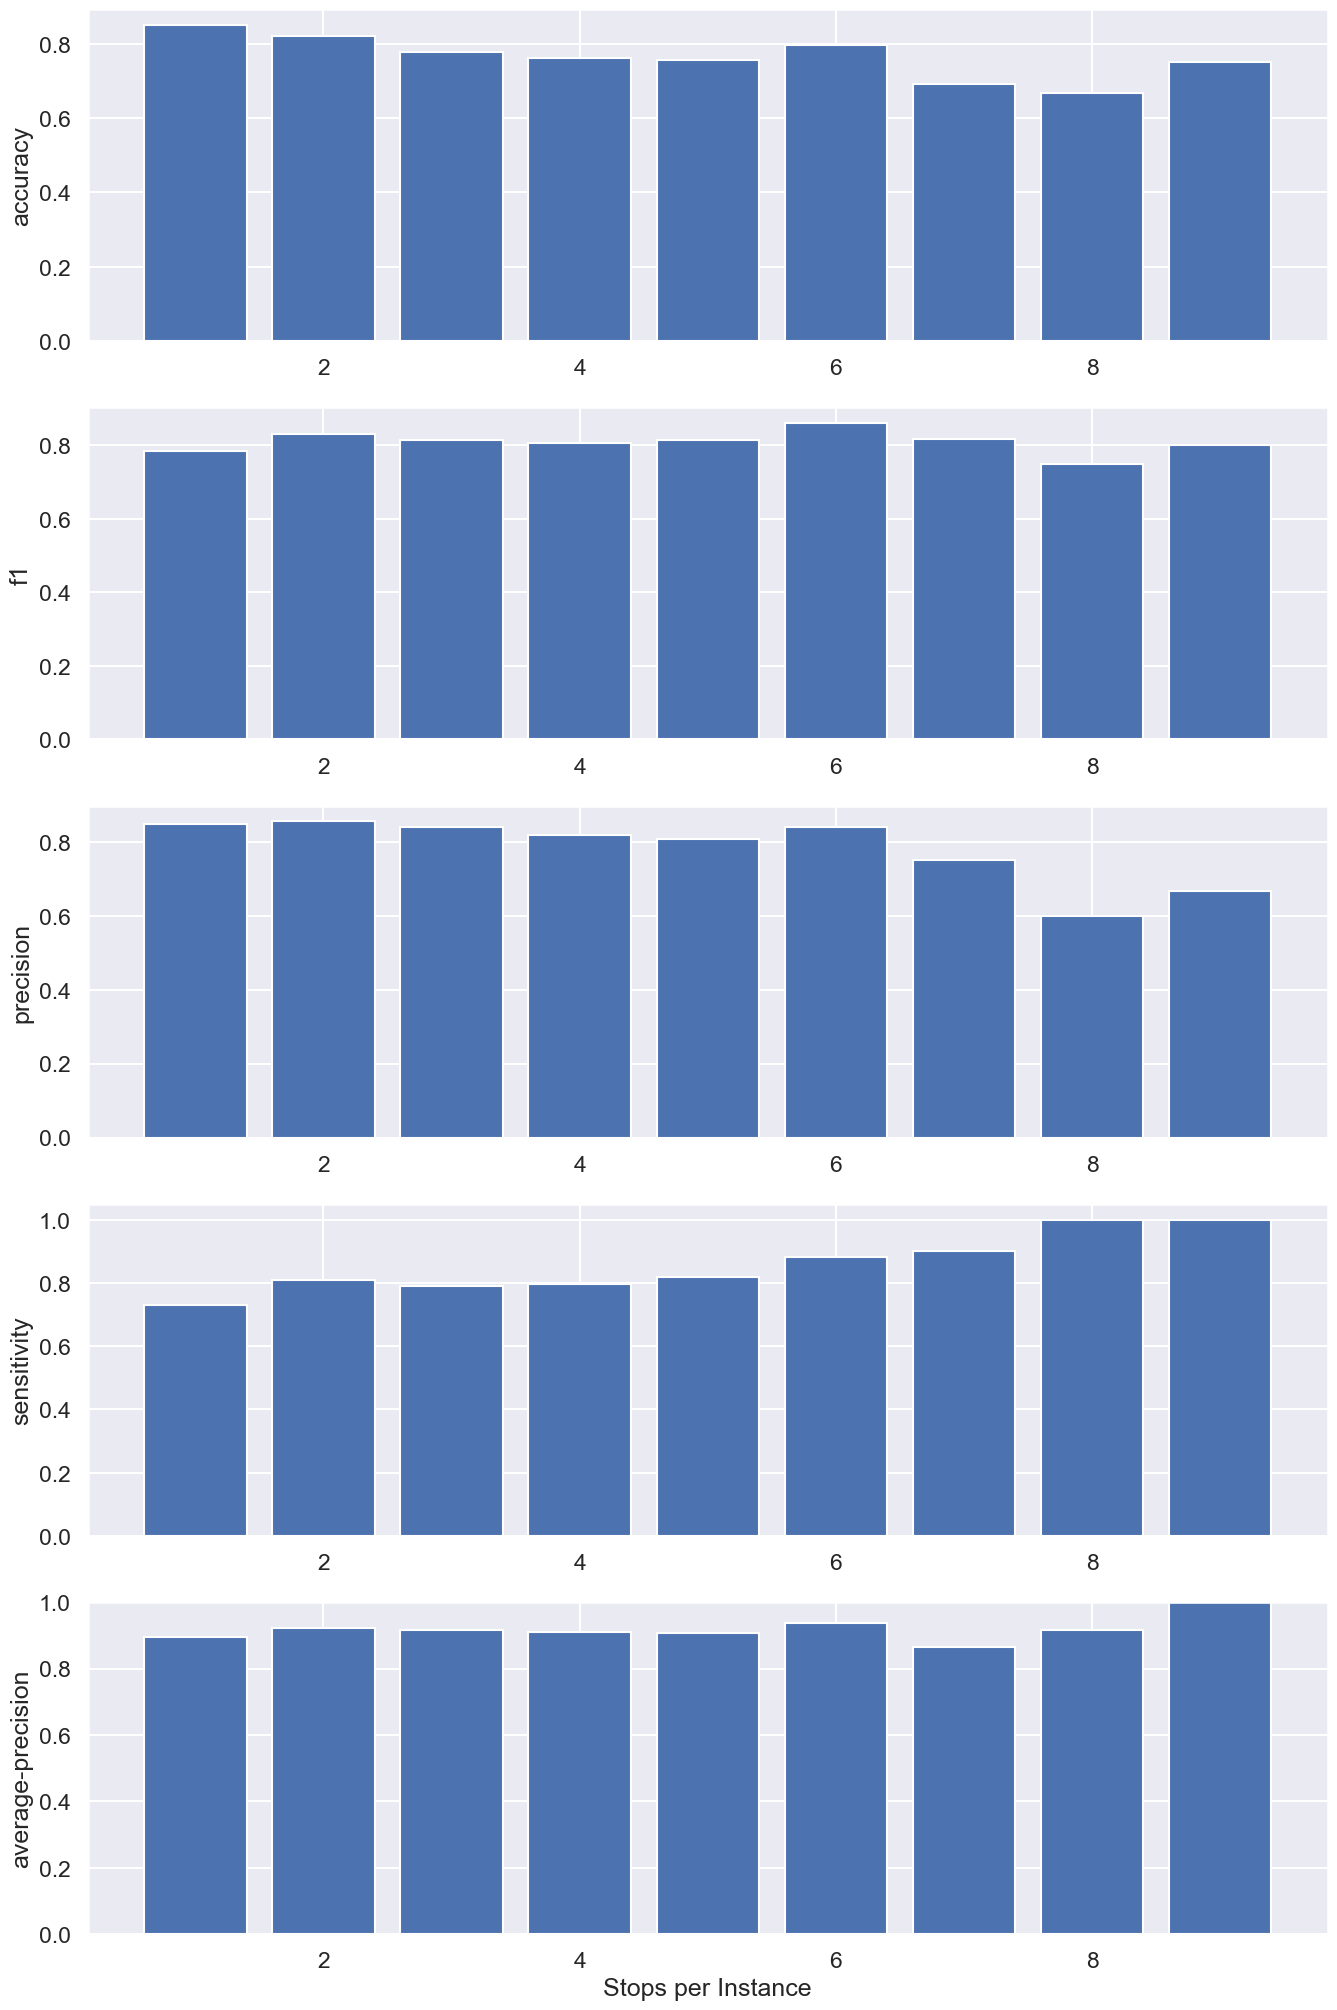

In [60]:
fig, ax = plt.subplots(len(clms), figsize=(16, len(clms)*5))

for i, clm in enumerate(clms):
    ax[i].bar(res.index, res[clm]);
    ax[i].set(
        ylabel=clm
    )
ax[-1].set(
    xlabel="Stops per Instance",
    ylim=[0, 1]
);

In [83]:
df

raw,y_pred_improvement,y_proba_improvement,label,n_stops,n_stacks
str,f32,f32,i64,i64,i64
"""dataset: X ins…",0.0,0.149976,0,1,16
"""dataset: X ins…",0.0,0.358387,0,1,20
"""dataset: X ins…",0.0,0.443568,0,1,27
"""dataset: X ins…",0.0,0.465123,0,1,22
"""dataset: B ins…",0.0,0.336665,0,2,15
"""dataset: A ins…",1.0,0.566169,1,4,28
"""dataset: C ins…",0.0,0.482687,0,1,18
"""dataset: X ins…",0.0,0.179359,0,1,6
"""dataset: C ins…",1.0,0.756419,1,1,15


In [84]:
from sklearn.metrics import classification_report

print(classification_report(df["label"], df["y_pred_improvement"]))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      5284
           1       0.84      0.77      0.81      4716

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



In [80]:
df["n_stops"].value_counts().sort("n_stops")

n_stops,counts
i64,u32
1,5471
2,2035
3,1601
4,590
5,221
6,59
7,13
8,6
9,4


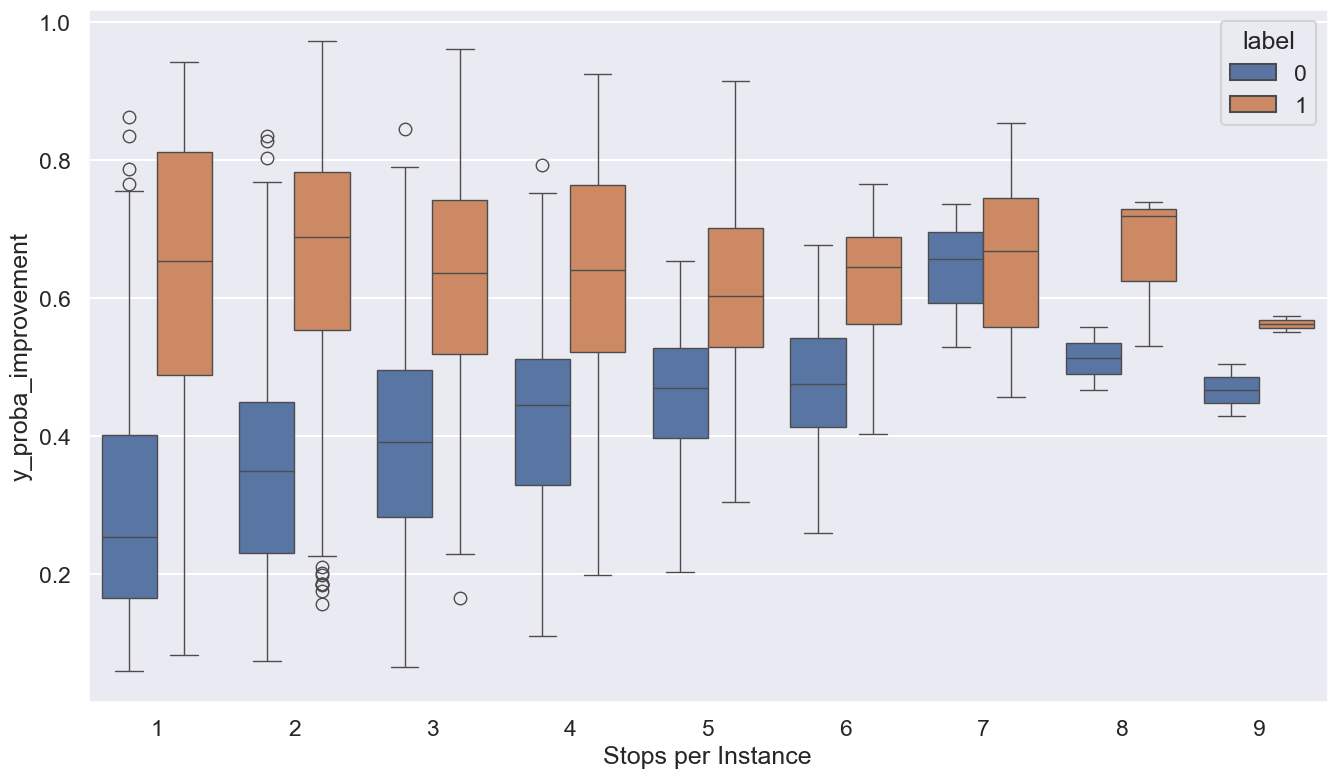

In [61]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=df.to_pandas(), x="n_stops", y="y_proba_improvement", hue="label");
plt.xlabel("Stops per Instance");

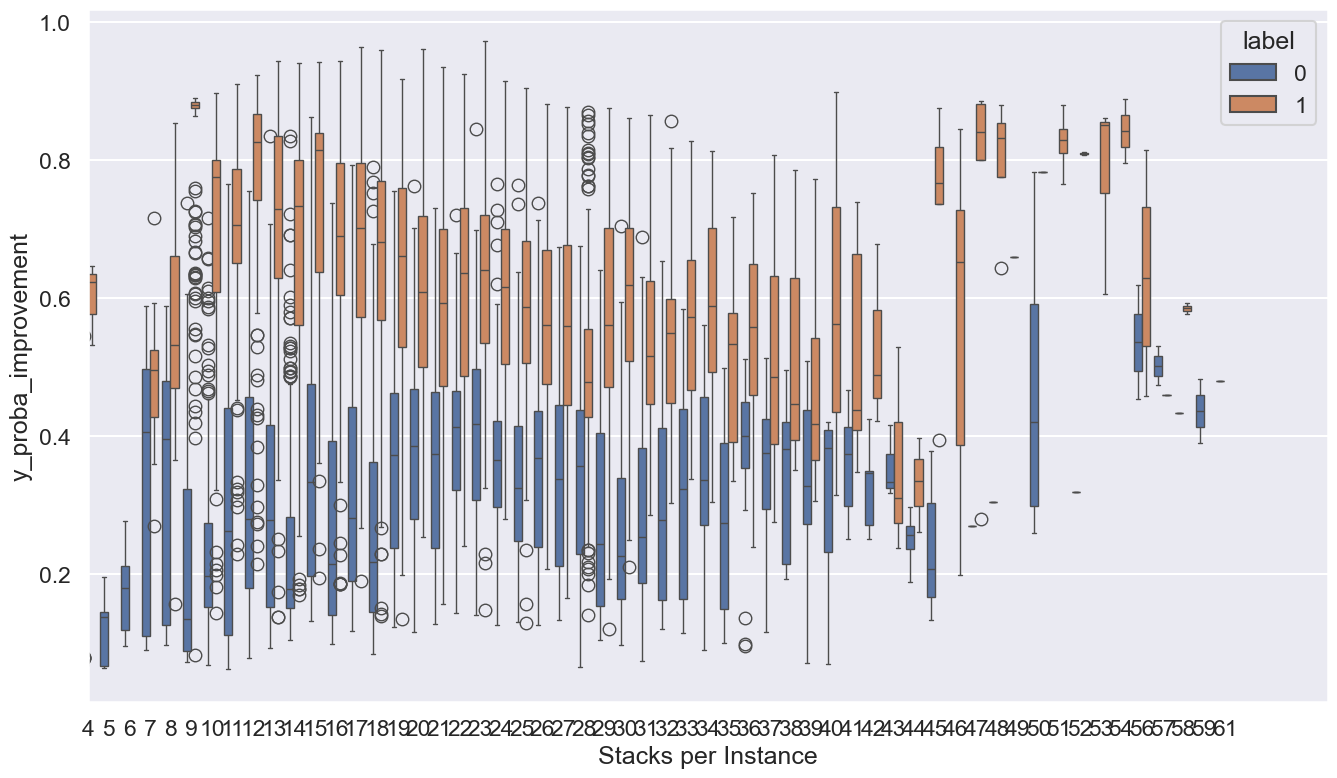

In [62]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=df.to_pandas(), x="n_stacks", y="y_proba_improvement", hue="label");
plt.xlabel("Stacks per Instance");
plt.xlim([0, 60]);
#plt.xticks(np.arange(0, 60, 10));

In [63]:
accuracy_score(df["label"], df["y_pred_improvement"])

0.8247

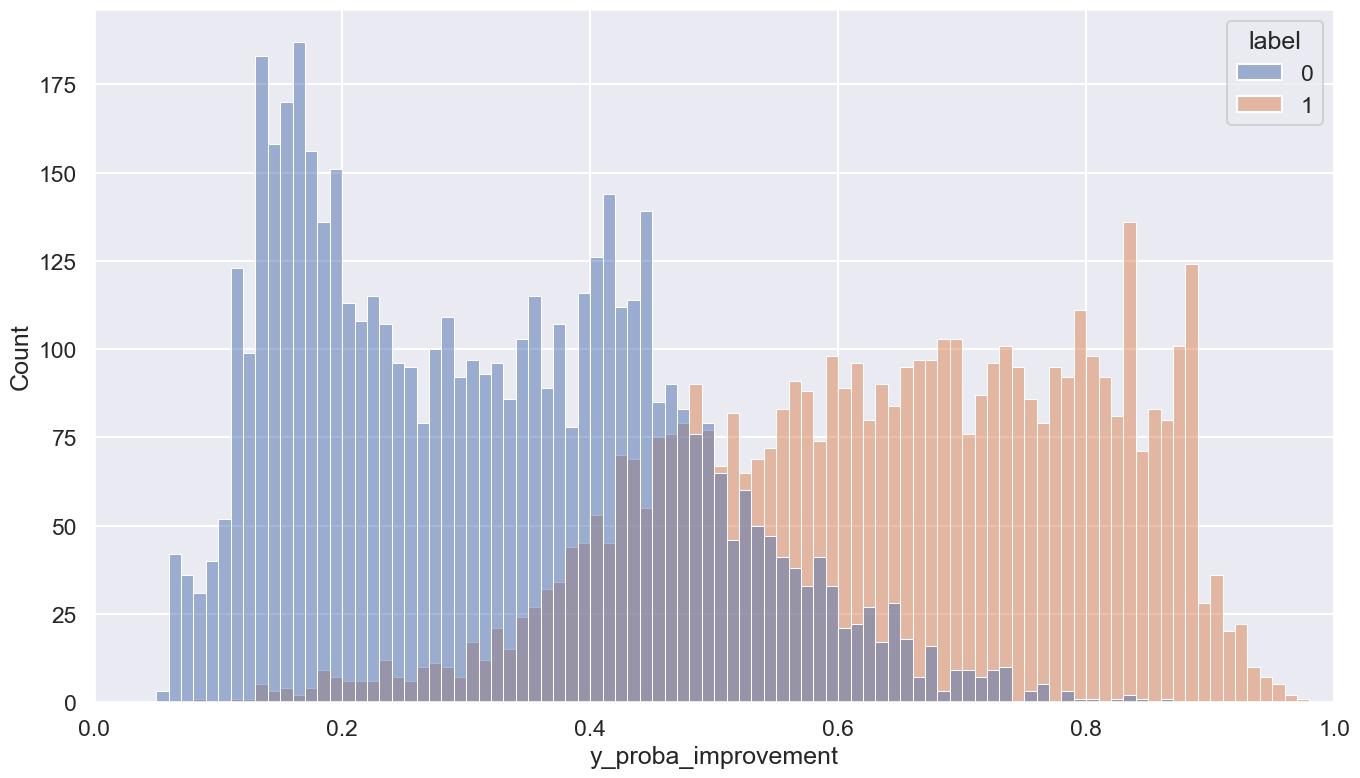

In [81]:
plt.figure(figsize=(16, 9))
sns.histplot(data=df.to_pandas(), x="y_proba_improvement", hue="label", bins=np.arange(0, 1.1, 0.01));
plt.xlim([0, 1]);

In [65]:
c[0, :15].round(2)

array([[1.21, 1.01, 0.78, 0.  , 0.  , 1.  , 0.  , 0.03, 0.42],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04],
       [1.8 , 1.2 , 0.52, 0.  , 0.  , 1.  , 0.  , 0.64, 0.04]])

### Visualize Attention Scores:

In [67]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 StackLevelInputFeatures (I  [(None, 80, 9)]              0         []                            
 nputLayer)                                                                                       
                                                                                                  
 MaskingLayer (Masking)      (None, 80, 9)                0         ['StackLevelInputFeatures[0][0
                                                                    ]']                           
                                                                                                  
 transformer_encoder (Trans  ((None, 80, 9),              312       ['MaskingLayer[0][0]']        
 formerEncoder)               (None, 5, 80, 80))                                              

In [68]:
from utils.DNN.utils import get_attention_scores
from utils.DNN.model_layers import TransformerEncoder


attention = get_attention_scores(model, model_inputs=cx, layer_name="transformer_encoder_5")
attention.shape
#cx[0][24].round(2)[:40]

(10000, 5, 80, 80)

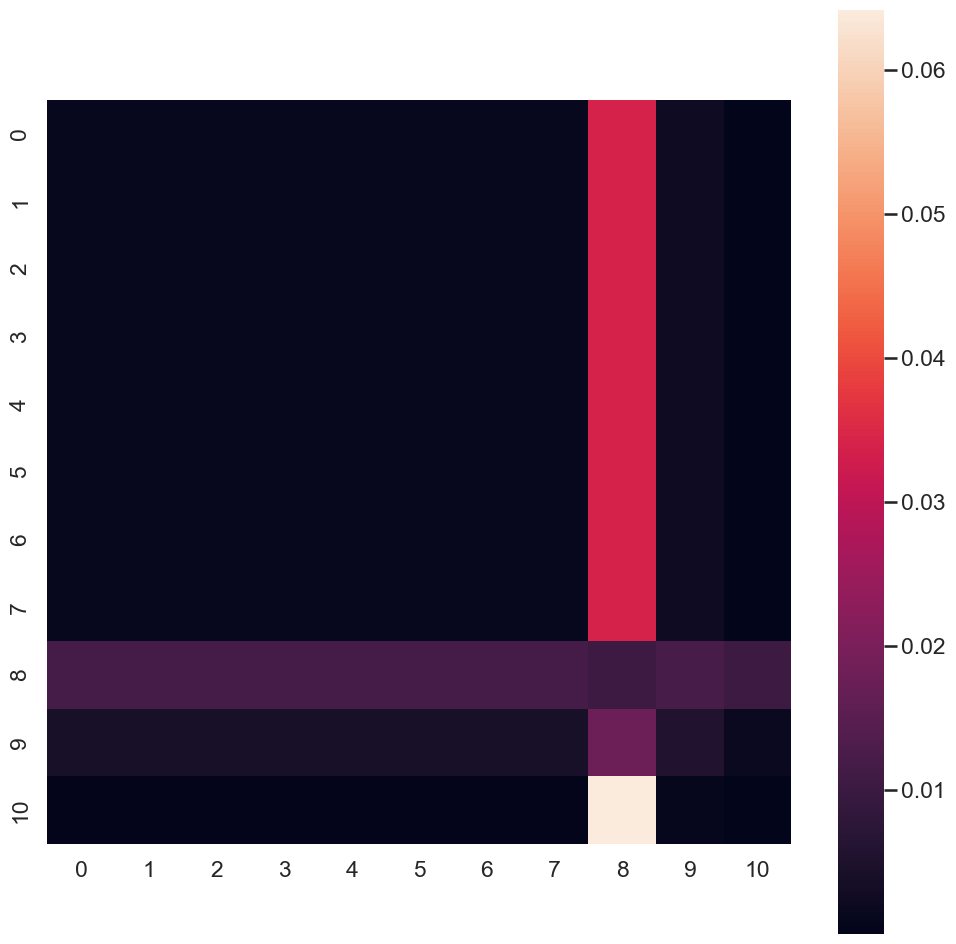

In [69]:
instance, head = 24, 3 # 18: 36 # 24 is a very simple but good example

attention_matrix = attention[instance, head, :, :]

# truncate:
n_inputs = np.argmax(np.all(cx[0][instance].round(2) == 0, axis=1))
attention_matrix = attention_matrix[:n_inputs, :n_inputs]

plt.figure(figsize=(12, 12))
sns.heatmap(attention_matrix.T, square=True);

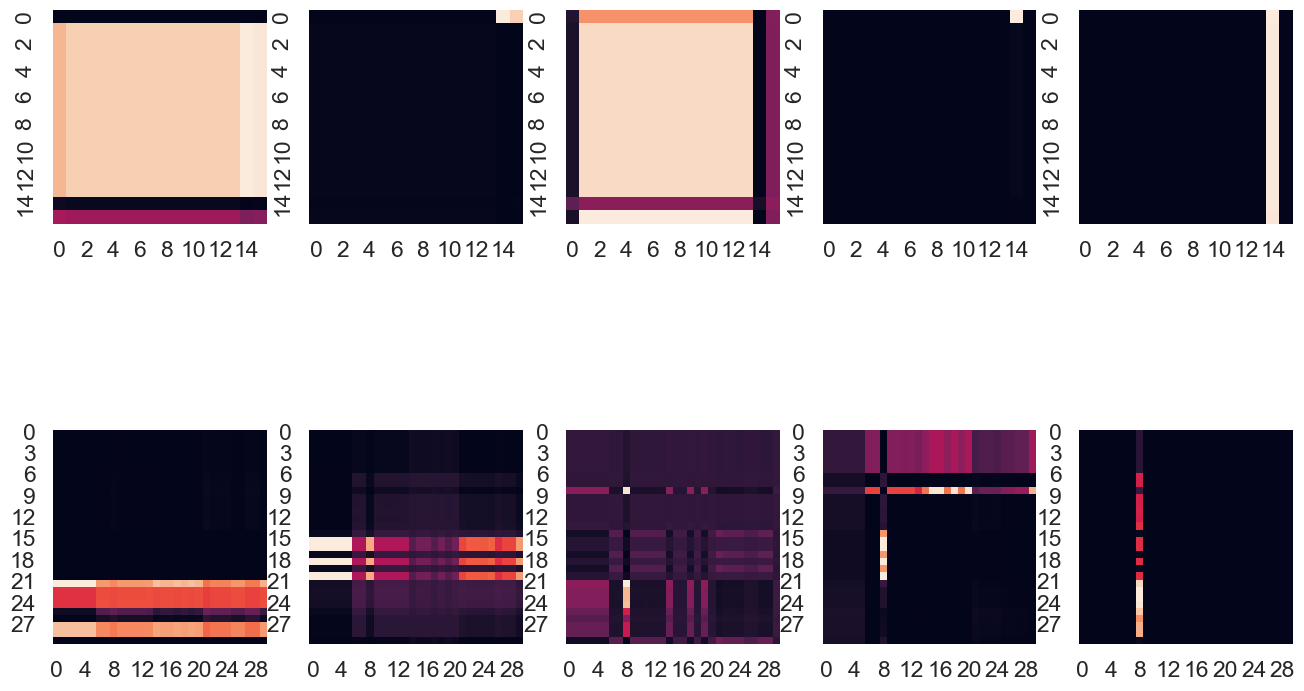

In [70]:
num_heads = 5
instances = [
    np.argmin(df["n_stops"]),
    np.argmax(df["n_stops"]),]
heads = list(range(num_heads))

fig, ax = plt.subplots(len(instances), num_heads, figsize=(16, len(instances)*5))

for i, instance in enumerate(instances):
    for h, head in enumerate(heads):
        
        attention_matrix = attention[instance, head, :, :]
        
        n_inputs = np.argmax(np.all(cx[0][instance].round(2) == 0, axis=1))
        attention_matrix = attention_matrix[:n_inputs, :n_inputs]
        
        sns.heatmap(
            attention_matrix.T,
            square=True,
            cbar=False,
            ax=ax[i, h]);

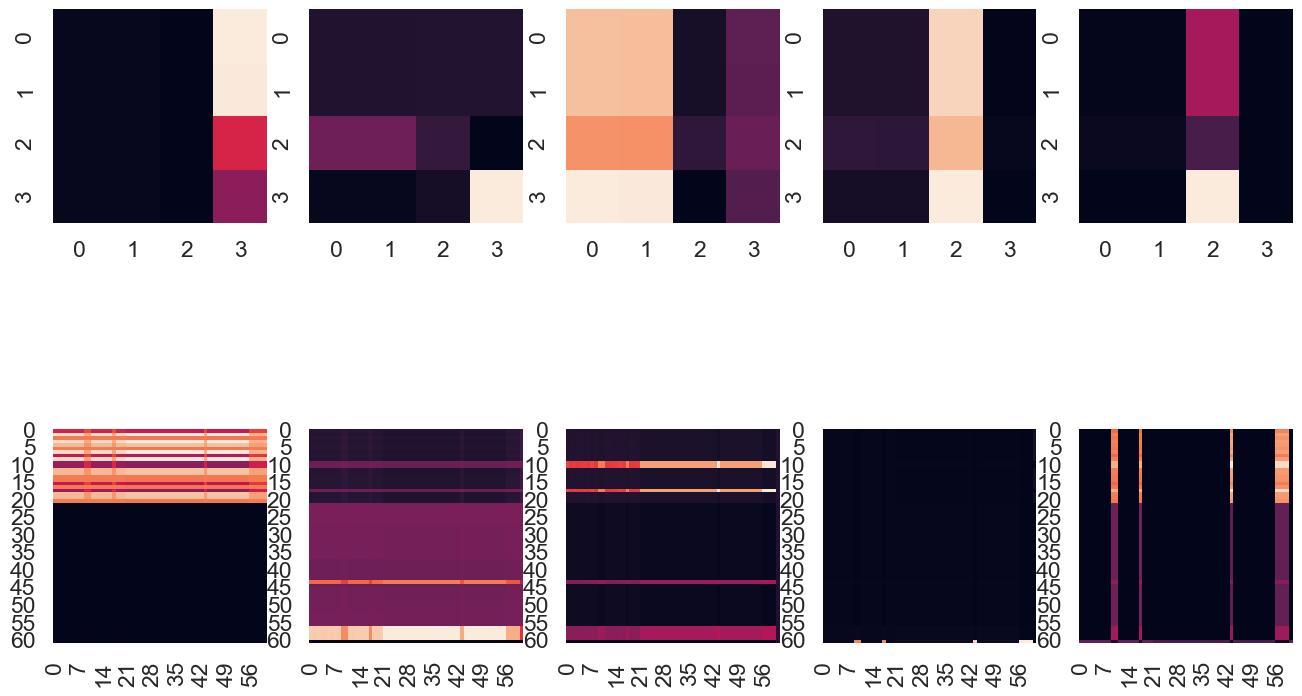

In [75]:
num_heads = 5
instances = [
    np.argmin(df["n_stacks"]),
    np.argmax(df["n_stacks"]),]
heads = list(range(num_heads))

fig, ax = plt.subplots(len(instances), num_heads, figsize=(16, len(instances)*5))

for i, instance in enumerate(instances):
    for h, head in enumerate(heads):
        
        attention_matrix = attention[instance, head, :, :]
        
        n_inputs = np.argmax(np.all(cx[0][instance].round(2) == 0, axis=1))
        attention_matrix = attention_matrix[:n_inputs, :n_inputs]
        
        sns.heatmap(
            attention_matrix.T,
            square=True,
            cbar=False,
            ax=ax[i, h]);